In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
from sqlalchemy import create_engine, text
from scipy.stats import zscore
import psycopg2
import os

In [2]:
os.chdir('..')

In [46]:
from db.connection import DatabaseConnection
from db.sql_preprocessor import DBFilter
from src.utils import missing_values_table, find_agg, convert_bytes_to_megabytes, fix_outlier, remove_outliers

In [4]:
db_connection = DatabaseConnection()

In [5]:
db_connection.connect()

Connected to the database.


In [6]:
query = "SELECT * FROM xdr_data"
df = db_connection.execute_query(query)

In [7]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [9]:
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [10]:
# Check for missing values in the original DataFrame df
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.
Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)       

In [11]:
# Example usage of find_agg on df
agg_result = find_agg(df, agg_column='MSISDN/Number', agg_metric='sum', col_name='Total_DL_Sum', top=5, order=False)

# Create a new DataFrame with the aggregated values
new_df = pd.DataFrame(agg_result)

# Print the new DataFrame
print("New DataFrame with Aggregated Values:")
print(new_df)


New DataFrame with Aggregated Values:
        MSISDN/Number  Total_DL_Sum
106855   8.823971e+14  8.823971e+14
106854   3.370000e+14  3.370000e+14
106853   3.197021e+12  3.197021e+12
13526    3.362632e+10  6.052738e+11
13180    3.362578e+10  5.716382e+11


In [12]:
# XDR analysis

In [13]:
# Using mean values for null fields

In [14]:
db_filter = DBFilter(df)

In [15]:
filtered_numeric_df = db_filter.filter_numeric_columns(threshold=50)

In [16]:
columns_to_exclude = ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']
for column in filtered_numeric_df.columns:
    if column not in columns_to_exclude:
        filtered_numeric_df[column].fillna(filtered_numeric_df[column].mean(), inplace=True)

In [17]:
filtered_numeric_df.head()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,770.000000,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,213.056424,176.837163,21660.940053,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,235.000000,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.000000,176.837163,21660.940053,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,524.751521,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,213.056424,176.837163,21660.940053,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,486.000000,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,213.056424,176.837163,21660.940053,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,565.000000,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,213.056424,176.837163,21660.940053,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [18]:
missing_values = filtered_numeric_df.isnull().sum()
print(missing_values)

Bearer Id                                    991
Start ms                                       0
End ms                                         0
Dur. (ms)                                      0
IMSI                                         570
MSISDN/Number                               1066
IMEI                                         572
Avg RTT DL (ms)                                0
Avg RTT UL (ms)                                0
Avg Bearer TP DL (kbps)                        0
Avg Bearer TP UL (kbps)                        0
TCP DL Retrans. Vol (Bytes)                    0
TCP UL Retrans. Vol (Bytes)                    0
DL TP < 50 Kbps (%)                            0
50 Kbps < DL TP < 250 Kbps (%)                 0
250 Kbps < DL TP < 1 Mbps (%)                  0
DL TP > 1 Mbps (%)                             0
UL TP < 10 Kbps (%)                            0
10 Kbps < UL TP < 50 Kbps (%)                  0
50 Kbps < UL TP < 300 Kbps (%)                 0
UL TP > 300 Kbps (%)

In [19]:
# Handle outliers using z-score for specific columns
columns_to_exclude = ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']
for column in filtered_numeric_df.columns:
    if column not in columns_to_exclude:
        z_scores = zscore(filtered_numeric_df[column])
        filtered_numeric_df[column + '_Outlier'] = (np.abs(z_scores) > 3).astype(int)
        filtered_numeric_df = filtered_numeric_df[filtered_numeric_df[column + '_Outlier'] == 0]  # Remove rows with outliers

In [20]:
user_xdr_sessions = filtered_numeric_df.groupby(['MSISDN/Number'])['Bearer Id'].count().reset_index(name='Number_of_xDR_sessions')

In [21]:
user_xdr_sessions.head()

,MSISDN/Number,Number_of_xDR_sessions
0,3.360100e+10,1
1,3.360100e+10,1
2,3.360100e+10,1
3,3.360101e+10,1
4,3.360101e+10,1


In [22]:
user_session_duration = filtered_numeric_df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Total_Session_Duration_ms')

In [23]:
user_session_duration['Total_Session_Duration_sec'] = user_session_duration['Total_Session_Duration_ms'] / 1000

In [24]:
user_session_duration.head()

,MSISDN/Number,Total_Session_Duration_ms,Total_Session_Duration_sec
0,3.360100e+10,116720.0,116.720
1,3.360100e+10,181230.0,181.230
2,3.360100e+10,134969.0,134.969
3,3.360101e+10,49878.0,49.878
4,3.360101e+10,18549.0,18.549


In [25]:
user_data_usage = filtered_numeric_df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()


In [26]:
user_data_usage.head()

,MSISDN/Number,Total DL (Bytes),Total UL (Bytes)
0,3.360100e+10,842637466.0,36053108.0
1,3.360100e+10,120755184.0,36104459.0
2,3.360100e+10,556659663.0,39306820.0
3,3.360101e+10,401993172.0,20327526.0
4,3.360101e+10,547096937.0,38481427.0


In [27]:
# Convert data usage to kilobytes
user_data_usage['Total DL (KB)'] = user_data_usage['Total DL (Bytes)'] / 1024
user_data_usage['Total UL (KB)'] = user_data_usage['Total UL (Bytes)'] / 1024

In [28]:
user_data_usage.head()

,MSISDN/Number,Total DL (Bytes),Total UL (Bytes),Total DL (KB),Total UL (KB)
0,3.360100e+10,842637466.0,36053108.0,822888.150391,35208.113281
1,3.360100e+10,120755184.0,36104459.0,117924.984375,35258.260742
2,3.360100e+10,556659663.0,39306820.0,543612.952148,38385.566406
3,3.360101e+10,401993172.0,20327526.0,392571.457031,19851.099609
4,3.360101e+10,547096937.0,38481427.0,534274.352539,37579.518555


In [29]:
# Convert data usage to kilobytes
user_data_usage['Total DL (MB)'] = user_data_usage['Total DL (Bytes)'] / 1024000
user_data_usage['Total UL (MB)'] = user_data_usage['Total UL (Bytes)'] / 1024000

In [30]:
user_data_usage.head()

,MSISDN/Number,Total DL (Bytes),Total UL (Bytes),Total DL (KB),Total UL (KB),Total DL (MB),Total UL (MB)
0,3.360100e+10,842637466.0,36053108.0,822888.150391,35208.113281,822.888150,35.208113
1,3.360100e+10,120755184.0,36104459.0,117924.984375,35258.260742,117.924984,35.258261
2,3.360100e+10,556659663.0,39306820.0,543612.952148,38385.566406,543.612952,38.385566
3,3.360101e+10,401993172.0,20327526.0,392571.457031,19851.099609,392.571457,19.851100
4,3.360101e+10,547096937.0,38481427.0,534274.352539,37579.518555,534.274353,37.579519


In [31]:
user_app_data_usage = filtered_numeric_df.groupby(['MSISDN/Number', 'Bearer Id'])[
    ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)']
].sum().reset_index()

In [32]:
user_app_data_usage.head()

,MSISDN/Number,Bearer Id,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
0,3.360100e+10,1.311448e+19,2206504.0,25631.0,3337123.0,1051882.0,837400.0,493962.0,14900201.0,6724347.0,10265105.0,16915876.0,811091133.0,1367528.0,377096990.0,9473882.0
1,3.360100e+10,7.349883e+18,2598548.0,62017.0,4197697.0,1137166.0,2828821.0,478960.0,5324251.0,7107972.0,770569.0,10451194.0,105035298.0,14714780.0,279557701.0,2152370.0
2,3.360100e+10,7.349883e+18,3148004.0,47619.0,3343483.0,99643.0,2436500.0,768880.0,2137272.0,19196298.0,16525919.0,2827981.0,529068485.0,9759228.0,495086501.0,6607171.0
3,3.360101e+10,1.304243e+19,251469.0,28825.0,5937765.0,3740728.0,2178618.0,106052.0,4393123.0,2584198.0,1157362.0,784730.0,388074835.0,3051292.0,25248001.0,10031701.0
4,3.360101e+10,7.349883e+18,1359904.0,28581.0,6309062.0,2019919.0,979859.0,911925.0,8027633.0,13012887.0,21177155.0,6051459.0,509243324.0,2989307.0,705348475.0,13467349.0


In [33]:
# Calculating basic metrics for the entire dataset
basic_metrics = filtered_numeric_df.describe()

In [34]:
print("Basic Metrics:")
print(basic_metrics)

Basic Metrics:
          Bearer Id       Start ms         End ms      Dur. (ms)  \
count  1.000330e+05  100578.000000  100578.000000  100578.000000   
mean   9.983252e+18     524.773162     523.445200  105692.138346   
std    2.885835e+18     266.477126     266.396069   60237.699258   
min    6.917538e+18      51.000000      51.000000    7142.000000   
25%    7.349883e+18     301.000000     300.000000   59711.750000   
50%    7.349883e+18     524.751521     523.918927   95232.500000   
75%    1.311448e+19     748.000000     749.000000  146040.750000   
max    1.318654e+19     999.000000     999.000000  291266.000000   

               IMSI  MSISDN/Number          IMEI  Avg RTT DL (ms)  \
count  1.002440e+05   9.997700e+04  1.002440e+05    100578.000000   
mean   2.082017e+14   3.704351e+10  4.236963e+13       200.711210   
std    1.860157e+10   1.065704e+12  1.777633e+13       111.007294   
min    2.082001e+14   3.360100e+10  4.400152e+11        51.000000   
25%    2.082010e+14   3.365

In [35]:
# Additional Metrics
# median
median_values = filtered_numeric_df.median()

In [36]:
print("\nMedian Values:")
print(median_values)


Median Values:
Bearer Id                    7.349883e+18
Start ms                     5.247515e+02
End ms                       5.239189e+02
Dur. (ms)                    9.523250e+04
IMSI                         2.082015e+14
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Length: 96, dtype: float64


In [37]:
# mode
mode_values = filtered_numeric_df.mode().iloc[0]

In [38]:
print("\nMode Values:")
print(mode_values)


Mode Values:
Bearer Id                    1.304243e+19
Start ms                     5.247515e+02
End ms                       5.239189e+02
Dur. (ms)                    8.639900e+04
IMSI                         2.082010e+14
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Name: 0, Length: 96, dtype: float64


In [39]:
# standard deviation
std_dev_values = filtered_numeric_df.std()

In [40]:
print("\nStandard Deviation Values:")
print(std_dev_values)


Standard Deviation Values:
Bearer Id                    2.885835e+18
Start ms                     2.664771e+02
End ms                       2.663961e+02
Dur. (ms)                    6.023770e+04
IMSI                         1.860157e+10
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Length: 96, dtype: float64


In [41]:
# variance
variance_values = filtered_numeric_df.var()

In [42]:
print("\nVariance Values:")
print(variance_values)


Variance Values:
Bearer Id                    8.328044e+36
Start ms                     7.101006e+04
End ms                       7.096687e+04
Dur. (ms)                    3.628580e+09
IMSI                         3.460186e+20
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Length: 96, dtype: float64


In [43]:
# Dispersion Parameters for Each Quantitative Variable
dispersion_params = filtered_numeric_df.describe().transpose()

# Additional Dispersion Parameters (if needed)
dispersion_params['range'] = filtered_numeric_df.max() - filtered_numeric_df.min()
dispersion_params['iqr'] = filtered_numeric_df.quantile(0.75) - filtered_numeric_df.quantile(0.25)

# Print Results
print("Dispersion Parameters for Each Quantitative Variable:")
print(dispersion_params[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'iqr']])


Dispersion Parameters for Each Quantitative Variable:
                                   mean           std           min  \
Bearer Id                  9.983252e+18  2.885835e+18  6.917538e+18   
Start ms                   5.247732e+02  2.664771e+02  5.100000e+01   
End ms                     5.234452e+02  2.663961e+02  5.100000e+01   
Dur. (ms)                  1.056921e+05  6.023770e+04  7.142000e+03   
IMSI                       2.082017e+14  1.860157e+10  2.082001e+14   
...                                 ...           ...           ...   
Gaming UL (Bytes)_Outlier  0.000000e+00  0.000000e+00  0.000000e+00   
Other DL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   
Other UL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   
Total UL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   
Total DL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   

                                    25%           50%           75%  \
Bearer Id             

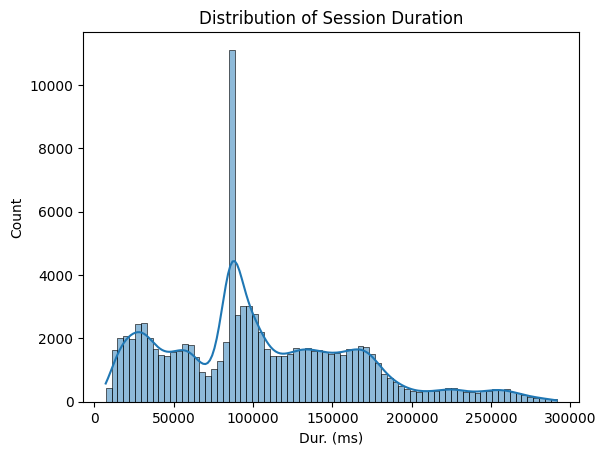

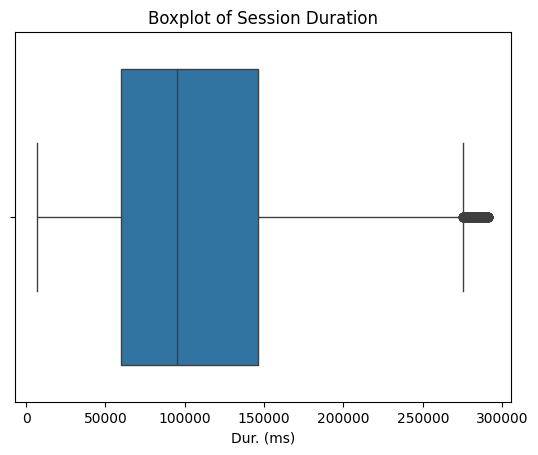

In [44]:
# Example for 'Dur. (ms)' using Seaborn
sns.histplot(filtered_numeric_df['Dur. (ms)'], kde=True)
pl.title('Distribution of Session Duration')
pl.show()

sns.boxplot(x=filtered_numeric_df['Dur. (ms)'])
pl.title('Boxplot of Session Duration')
pl.show()


In [59]:
filtered_numeric_df_out = remove_outliers(filtered_numeric_df, 'Dur. (ms)', z_threshold=2)

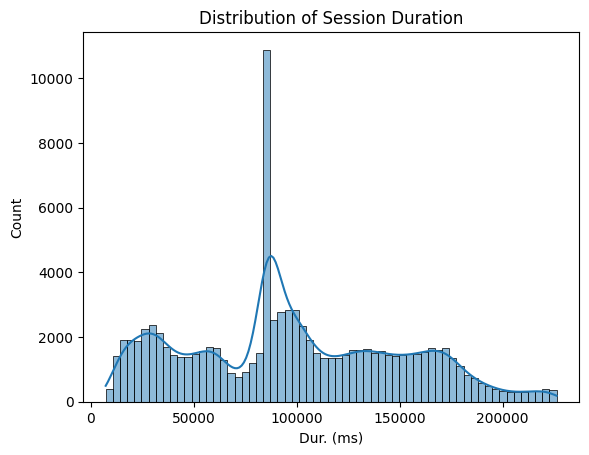

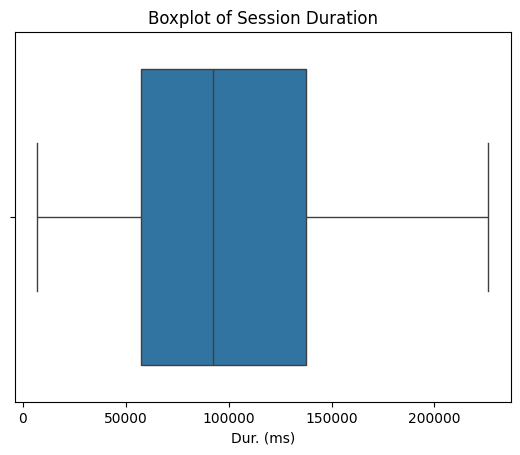

In [60]:
# Example for 'Dur. (ms)' using Seaborn
sns.histplot(filtered_numeric_df_out['Dur. (ms)'], kde=True)
pl.title('Distribution of Session Duration')
pl.show()

sns.boxplot(x=filtered_numeric_df_out['Dur. (ms)'])
pl.title('Boxplot of Session Duration')
pl.show()